##  Data Proprecessing 

In [9]:
#Import Libraries.
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15, 6

import statsmodels as sm
import statsmodels.api as smt 
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math 
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

In [2]:
#load the data and make parsed datetime as index
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
data = pd.read_csv('UnemploymentRateJan1986-Dec2018.csv', parse_dates=['Months'], 
                                  index_col='Months',date_parser=dateparse)

In [3]:
data.head(10)

,Unemployment_Rates
Months,
1986-01-01,8.53
1986-02-01,8.92
1986-03-01,8.48
1986-04-01,8.06
1986-05-01,7.71
1986-06-01,7.39
1986-07-01,7.86
1986-08-01,7.93
1986-09-01,8.12


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
#Gathering general information by info()and describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1986-01-01 to 2018-12-01
Data columns (total 1 columns):
Unemployment_Rates    396 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


In [6]:
data.describe()

,Unemployment_Rates
count,396.000000
mean,6.726212
std,1.811832
min,3.930000
25%,5.410000
50%,6.210000
75%,7.947500
max,11.990000


In [7]:
#checking if the value is Not a Number (NaN)
data.isnull().sum()

Unemployment_Rates    0
dtype: int64

In [8]:
# Train - Test Split 
# We set the last 12 months of 2018 as the Test Validation Set
# and date from 1986-01 to 2017-12 as Train set 
train = data[:len(data)-12]
validation =data[-12:]

## Exploratory Data Analysis  

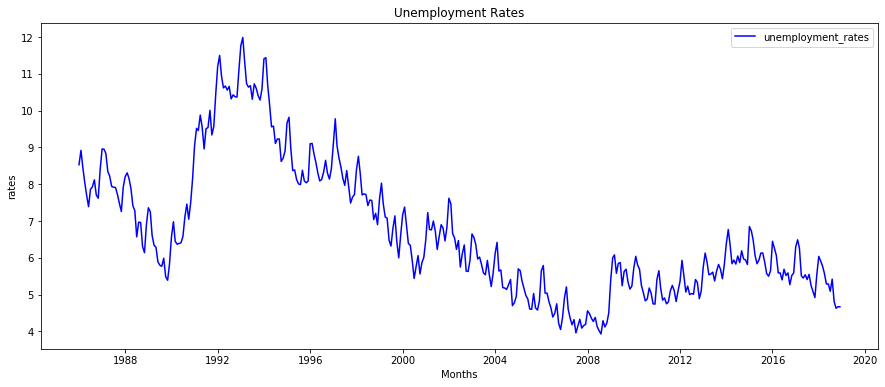

In [10]:
# Plot original Unemployment Rates timeseries
plt.figure()
plt.plot(data, color='blue', label='unemployment_rates')
plt.title('Unemployment Rates')
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()

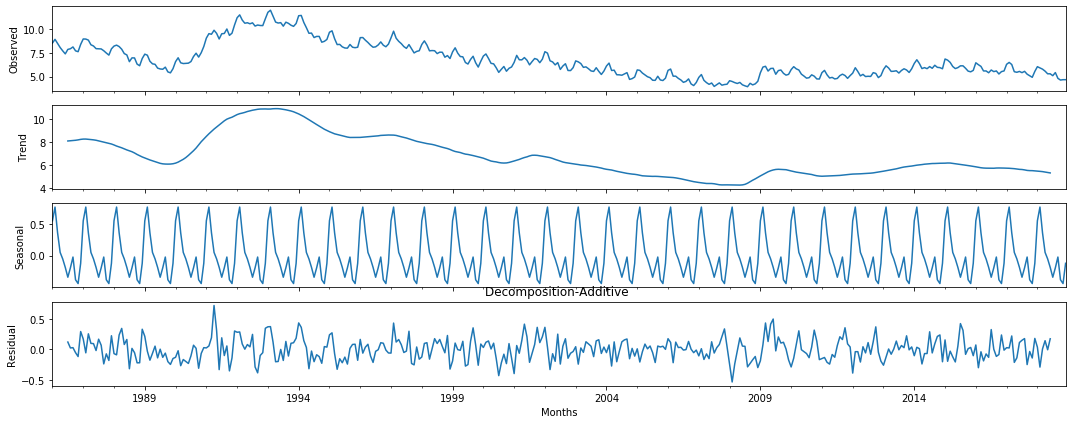

In [11]:
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
# Visually check if the timeseries contain seasonality component 
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.Series(data["Unemployment_Rates"])
result_Additive = seasonal_decompose(series, model='Additive')
result_Additive.plot()
plt.title('Decomposition-Additive ') 
plt.show()

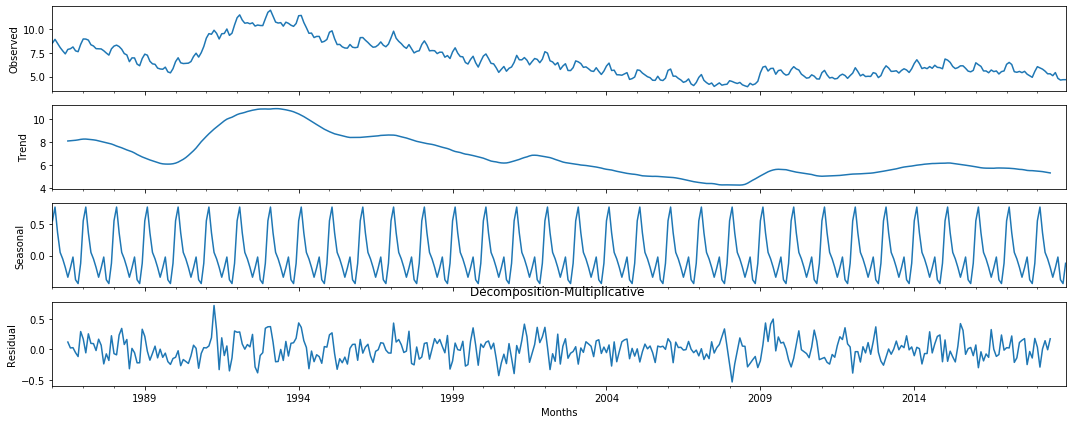

In [12]:
# As observed from the timeseries decomposition,
# it contains seasonalal components 
# Therefore, we will use advanced models which account for seasonality component 
# Such as  Holt-Winters, Seasoanl ARIMA, Neural Network 
result_Multiplicative= seasonal_decompose(series, model='Multiplicative')
result_Multiplicative.plot()
plt.title('Decomposition-Multiplicative ') 
plt.show()

## Model Evaluation 


### Model 1 Decomposition Model

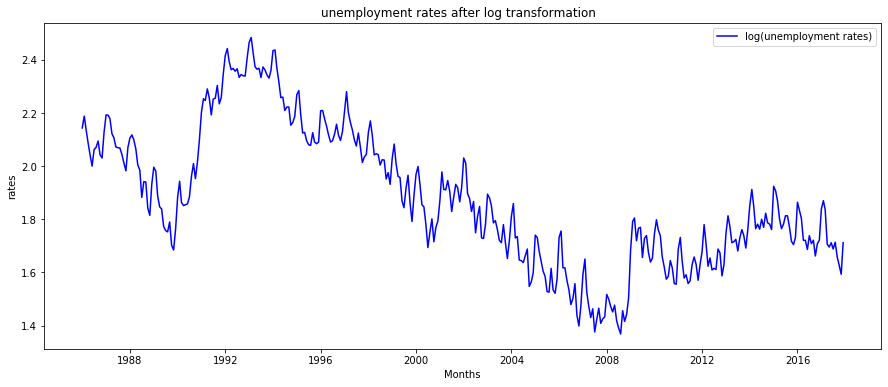

In [13]:
#log transformation

train_log=np.log(train)
plt.plot(train_log, color='blue', label='log(unemployment rates)')
plt.title('unemployment rates after log transformation  ')
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()

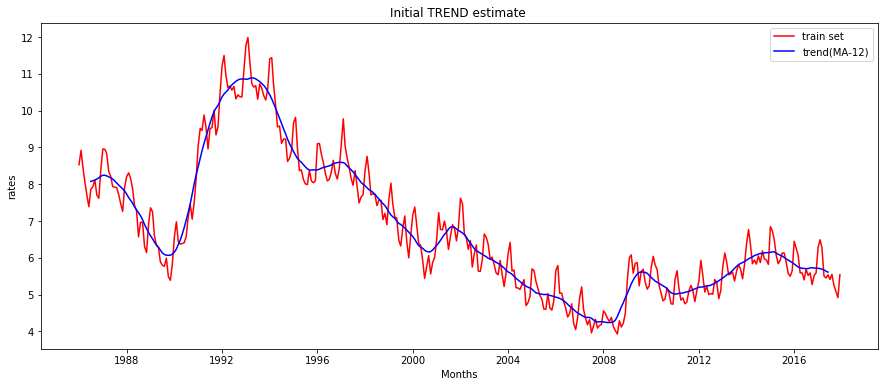

In [14]:

#Pre-processing：step 1. initial trend estaimae：here is some noise in realizing the forward trend here.
#We will use moving average as the smoothing technique to model these trends and then remove them from the series.

Trend_not_shifted = train.rolling(2, center = True).mean().rolling(12,center = True).mean()
Trend=Trend_not_shifted.shift(-1) 

plt.figure()
plt.plot(train, color='red',label='train set') 
plt.plot(Trend, color='blue',label='trend(MA-12)') 
plt.title('Initial TREND estimate ') 
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()


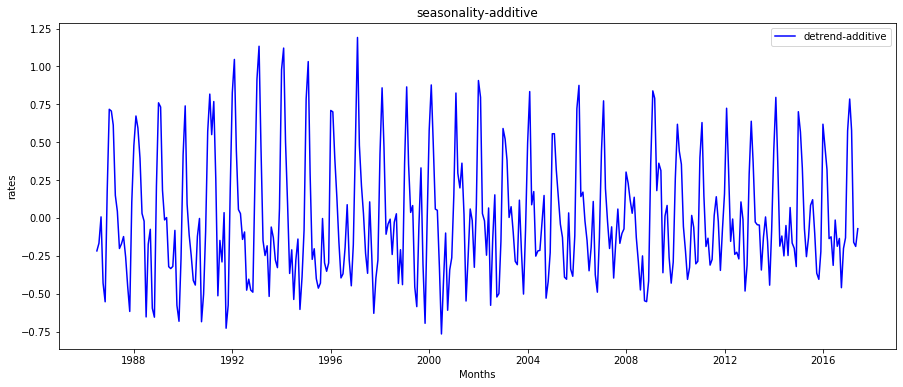

In [15]:
##Pre-processing：step 2:(de-trend seasonal)the selection of decomposition type 
#--additive and multiplicative
detrend_addi=train-Trend
detrend_multi=train/Trend
plt.figure()
plt.plot(detrend_addi, color='blue', label='detrend-additive')
plt.title('seasonality-additive')
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()


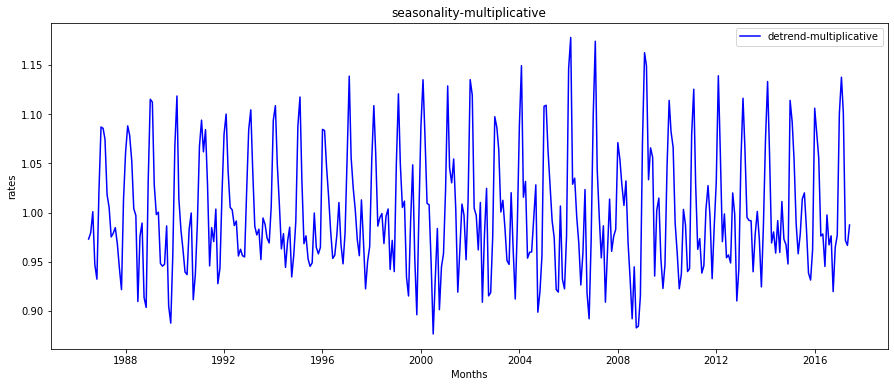

In [16]:
plt.figure()
plt.plot(detrend_multi, color='blue', label='detrend-multiplicative')
plt.title('seasonality-multiplicative')
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()

In [17]:
##Pre-processing：step3. Extract the seasonal index and obtain the seasonal adjusted series 

#3.1Extract the seasonal index
# Additive Decompostion
detrend_addi_zero= np.nan_to_num(detrend_addi)
monthly_S = np.reshape(detrend_addi_zero, (32,12)) 
monthly_avg = np.mean(monthly_S[1:32,:], axis=0)
#Multiplicative Decompostion
detrend_multi_zero= np.nan_to_num(detrend_multi)
monthly_S_m = np.reshape(detrend_multi_zero, (32,12)) 
monthly_avg_m = np.mean(monthly_S_m[1:32,:], axis=0)

In [18]:
#3.2 Normalize the seasonal index
# Additive 
mean_allmonth = monthly_avg.mean() 
monthly_avg_normalized = monthly_avg - mean_allmonth 

#Multiplicative 
Normalized_constant = 12/(monthly_avg_m.sum())
monthly_avg_normalized_m = Normalized_constant*monthly_avg_m



In [19]:
monthly_avg_normalized

array([ 0.54235663,  0.76788082,  0.35525986,  0.04392921, -0.05343638,
       -0.19178315, -0.33826165, -0.19362455, -0.01654122, -0.36507616,
       -0.41721326, -0.13349014])

In [20]:
monthly_avg_normalized_m

array([1.09900542, 1.13479779, 1.07107742, 1.02295038, 1.00901129,
       0.98808633, 0.9309125 , 0.9530925 , 0.98366641, 0.92863021,
       0.91843098, 0.96033876])

In [21]:
#3.3 tiling seasonal index to match the shape of training data 
tiled_avg = np.tile(monthly_avg_normalized, 32)  
tiled_avg=np.reshape(tiled_avg,(12*32,1))

tiled_avg_m = np.tile(monthly_avg_normalized_m, 32)  
tiled_avg_m=np.reshape(tiled_avg_m,(12*32,1))

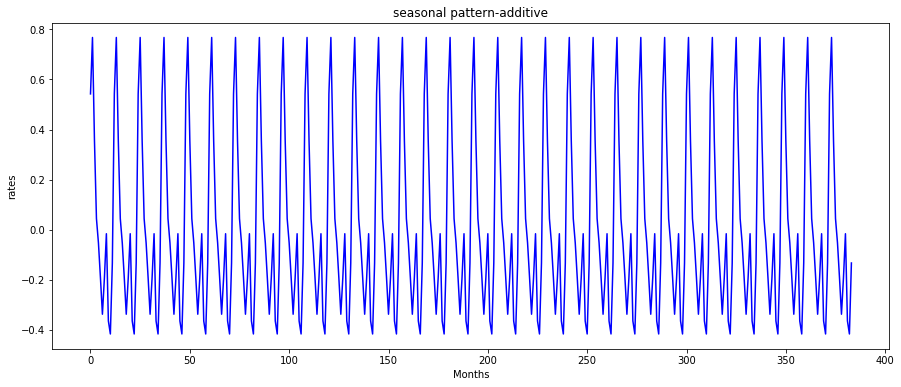

In [22]:
plt.figure()
plt.plot(tiled_avg, color='blue')
plt.title('seasonal pattern-additive')
plt.xlabel('Months')
plt.ylabel('rates')
plt.show()

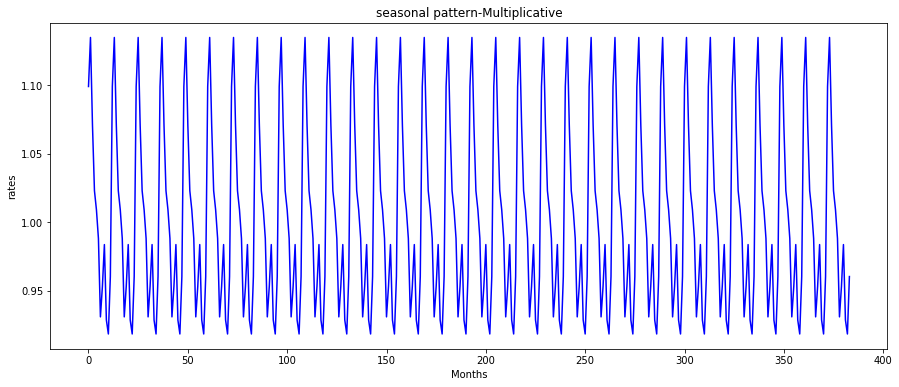

In [23]:
plt.figure()
plt.plot(tiled_avg_m, color='blue')
plt.title('seasonal pattern-Multiplicative')
plt.xlabel('Months')
plt.ylabel('rates')
plt.show()

In [24]:
##Pre-processing：3.4 Calculate the seasonal adjusted data
##Subtract the seasonal index from the original data(de-seasonal)
# additive
seasonally_adjusted = train - tiled_avg
seasonally_adjusted.head()

,Unemployment_Rates
Months,
1986-01-01,7.987643
1986-02-01,8.152119
1986-03-01,8.124740
1986-04-01,8.016071
1986-05-01,7.763436


In [25]:
# multiplication
seasonally_adjusted_m = train/tiled_avg_m
seasonally_adjusted_m.head()

,Unemployment_Rates
Months,
1986-01-01,7.761563
1986-02-01,7.860431
1986-03-01,7.917261
1986-04-01,7.879170
1986-05-01,7.641143


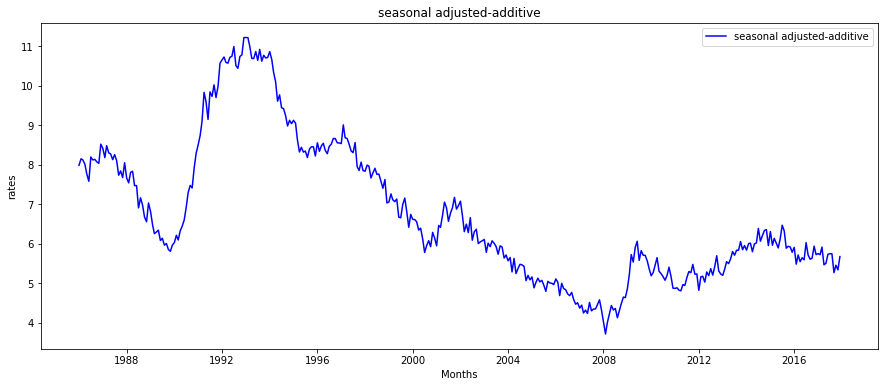

In [26]:

#Plot the seasonally adjusted data:
plt.figure()
plt.plot(seasonally_adjusted, color='blue', label='seasonal adjusted-additive')
plt.title('seasonal adjusted-additive')
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()

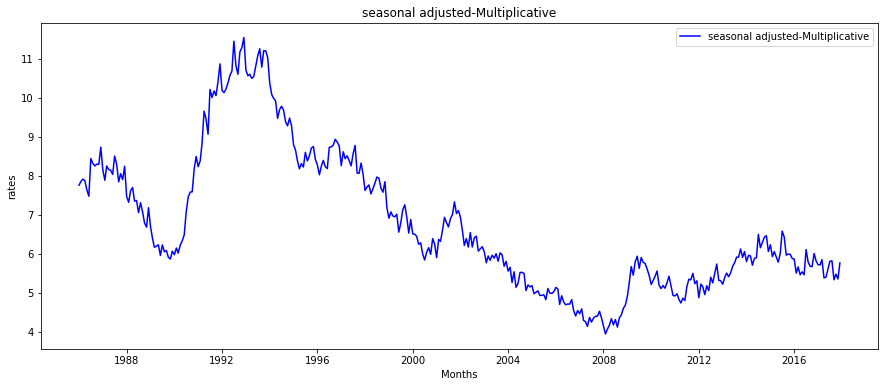

In [27]:
#Plot the seasonally adjusted data:
plt.figure()
plt.plot(seasonally_adjusted_m, color='blue', label='seasonal adjusted-Multiplicative')
plt.title('seasonal adjusted-Multiplicative')
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()

In [28]:
##Pre-processing：step 4re-estimate the trend-cycle component 
#based on the seasonally adjusted data

# To be noted: we not extrapolating a linear regression model,
# Instead, we use 2-MA（2）to forecast trend for the test 12 months
T_final = seasonally_adjusted.rolling(2, center=True).mean().rolling(2, center = True).mean().shift(-1) 
T_final_m = seasonally_adjusted_m.rolling(2, center=True).mean().rolling(2, center = True).mean().shift(-1) 
T_final=T_final
T_final_m=T_final_m

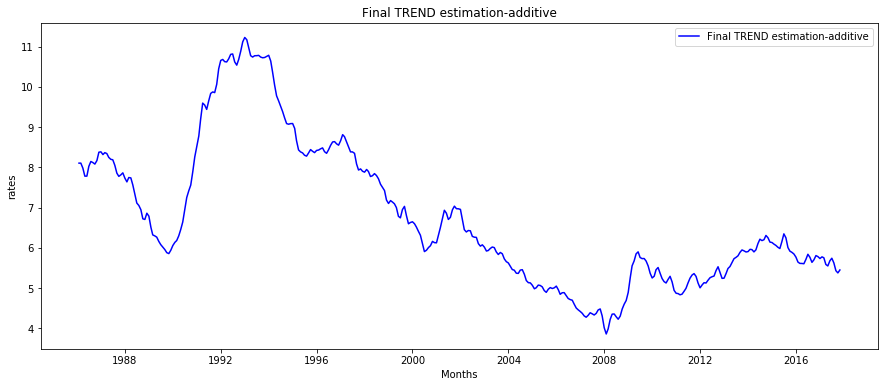

In [29]:
# This plot is used to check if 2-MA(2) can successfully smooth the trend
# Therefore, we use 2-MA(2) to do the future forecast trend 
plt.figure()
plt.plot(T_final, color='blue', label='Final TREND estimation-additive')
plt.title('Final TREND estimation-additive')
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()

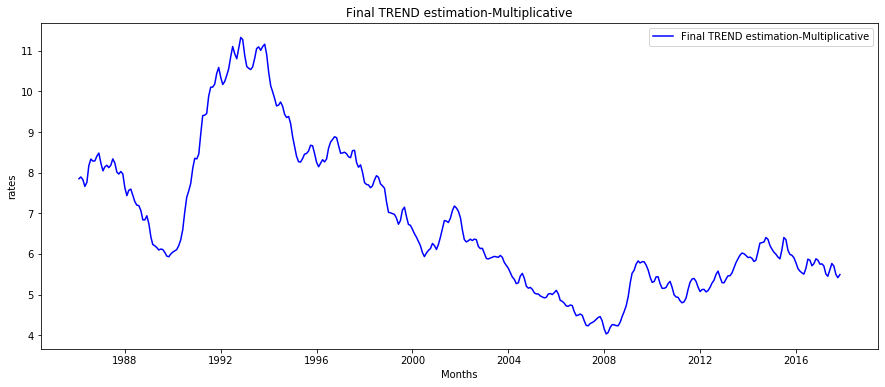

In [30]:
plt.figure()
plt.plot(T_final_m, color='blue', label='Final TREND estimation-Multiplicative')
plt.title('Final TREND estimation-Multiplicative')
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()

In [31]:
T_final=T_final[1:383]
T_final

# after 2-MA(2), we have null value for 2017-12
# will then forecast 13 one-step ahead value

,Unemployment_Rates
Months,
1986-02-01,8.104155
1986-03-01,8.104418
1986-04-01,7.980080
1986-05-01,7.781182
1986-06-01,7.781316
...,...
2017-07-01,5.742983
2017-08-01,5.625513
2017-09-01,5.432946


In [32]:
## T_final_m=T_final_m[1:383]
T_final_m


# after 2-MA(2), we have null value for 2017-12
# will then forecast 13 one-step ahead value

,Unemployment_Rates
Months,
1986-01-01,NaN
1986-02-01,7.849922
1986-03-01,7.893531
1986-04-01,7.829186
1986-05-01,7.660140
...,...
2017-08-01,5.698744
2017-09-01,5.494673
2017-10-01,5.414130


In [33]:
#forecast with the fit model
trend_1=T_final['Unemployment_Rates'].to_list()
for i in range(13):
    trend_1.append(np.mean(trend_1[-2:]))
    
trend_2=T_final_m['Unemployment_Rates'].to_list()
for i in range(13):
    trend_2.append(np.mean(trend_1[-2:]))

In [34]:
forecast_trend=trend_1[-12:]
forecast_trend

[5.4326803315412135,
 5.423646393369171,
 5.428163362455193,
 5.425904877912181,
 5.427034120183687,
 5.4264694990479345,
 5.42675180961581,
 5.426610654331872,
 5.426681231973841,
 5.426645943152857,
 5.426663587563349,
 5.426654765358103]

In [35]:
forecast_trend_m=trend_2[-12:]
forecast_trend_m

[5.426659176460726,
 5.426659176460726,
 5.426659176460726,
 5.426659176460726,
 5.426659176460726,
 5.426659176460726,
 5.426659176460726,
 5.426659176460726,
 5.426659176460726,
 5.426659176460726,
 5.426659176460726,
 5.426659176460726]

In [36]:
forecast_Seasonal=tiled_avg[:12]
forecast_Seasonal

array([[ 0.54235663],
       [ 0.76788082],
       [ 0.35525986],
       [ 0.04392921],
       [-0.05343638],
       [-0.19178315],
       [-0.33826165],
       [-0.19362455],
       [-0.01654122],
       [-0.36507616],
       [-0.41721326],
       [-0.13349014]])

In [37]:
forecast_Seasonal_m=tiled_avg_m[:12]
forecast_Seasonal_m

array([[1.09900542],
       [1.13479779],
       [1.07107742],
       [1.02295038],
       [1.00901129],
       [0.98808633],
       [0.9309125 ],
       [0.9530925 ],
       [0.98366641],
       [0.92863021],
       [0.91843098],
       [0.96033876]])

In [38]:
final_forecast=(forecast_trend+forecast_Seasonal.T).T
final_forecast

array([[5.97503696],
       [6.19152722],
       [5.78342322],
       [5.46983409],
       [5.37359774],
       [5.23468634],
       [5.08849016],
       [5.2329861 ],
       [5.41014001],
       [5.06156978],
       [5.00945033],
       [5.29316462]])

In [39]:
final_forecast_m=(forecast_trend_m*forecast_Seasonal_m.T).T
final_forecast_m

array([[5.96392784],
       [6.15816083],
       [5.81237211],
       [5.55120306],
       [5.47556039],
       [5.36200776],
       [5.05174488],
       [5.17210815],
       [5.33802235],
       [5.03935968],
       [4.98401193],
       [5.21143114]])

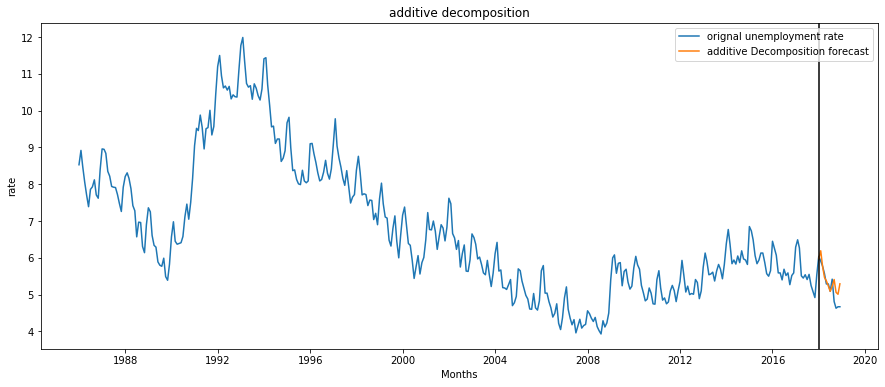

In [40]:
#plot the forecasting results vs orginal data
plt.figure()
plt.plot(data,label='orignal unemployment rate')
plt.plot(validation.index, final_forecast, label='additive Decomposition forecast')
plt.legend(loc=1)
plt.title("additive decomposition")
plt.xlabel("Months")
plt.ylabel("rate")
plt.axvline(data.index[len(data[:384])],color='black')
plt.show()

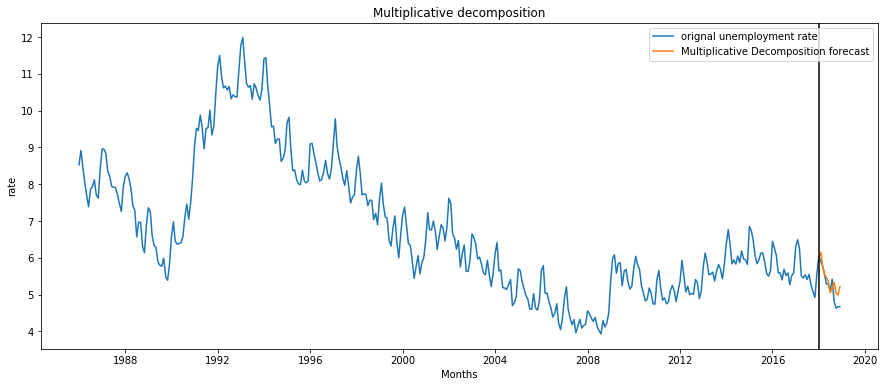

In [41]:
#plot the forecasting results vs orginal data
plt.figure()
plt.plot(data,label='orignal unemployment rate')
plt.plot(validation.index, final_forecast_m, label='Multiplicative Decomposition forecast')
plt.legend(loc=1)
plt.title("Multiplicative decomposition")
plt.xlabel("Months")
plt.ylabel("rate")
plt.axvline(data.index[len(data[:384])],color='black')
plt.show()

In [42]:
#check the accuracy of the forecast by MSE -additive
def MSE(a,b):
    return np.mean(np.power(a-b,2)) 
true=np.asarray(validation) 
final_forecast=np.asarray(final_forecast).reshape(-1,1) 
MSE_Decomposition_addi=MSE(true,final_forecast)
MSE_Decomposition_addi

0.09904404481642622

In [43]:
#check the accuracy of the forecast by MSE--multi 
def MSE(a,b):
    return np.mean(np.power(a-b,2)) 
true=np.asarray(validation) 
final_forecast_m=np.asarray(final_forecast_m).reshape(-1,1) 
MSE_Decomposition_multi=MSE(true,final_forecast_m)
MSE_Decomposition_multi

0.08411981403354755

### Model 2 Holt Winter

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# set seasonal as additive or multiplicative

fit_add = ExponentialSmoothing(train, seasonal_periods=12,damped=True ,trend='add', 
                            seasonal='add').fit()
fit_mul = ExponentialSmoothing(train, seasonal_periods=12,damped=True, trend='add', 
                            seasonal='mul').fit()

In [45]:
#finding the best fitting parameters,
results = pd.DataFrame(index=[r"$\alpha$",\
                            r"$\beta$",\
                            r"$\phi$",\
                            r"$\gamma$",\
                            r"$l_0$",\
                            "$b_0$",\
                            "SSE"])
# ExponentialSmoothing() object has following attributes
params = ['smoothing_level', \
          'smoothing_slope', \
          'damping_slope', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_slope']

# check out the performance of additive and multiplicative
results["Additive"]       = [fit_add.params[p] for p in params] + [fit_add.sse]
results["Multiplicative"] = [fit_mul.params[p] for p in params] + [fit_mul.sse] 

In [46]:
#%%
print("Forecasting Unemployment Rates using Holt-Winters method with \n \
      both additive and multiplicative seasonality.")
print(results)

Forecasting Unemployment Rates using Holt-Winters method with 
       both additive and multiplicative seasonality.
           Additive  Multiplicative
$\alpha$   0.577861        0.513215
$\beta$    0.168289        0.238802
$\phi$     0.905837        0.899367
$\gamma$   0.073612        0.000000
$l_0$      7.223258        7.328022
$b_0$      0.024430        0.016469
SSE       19.991173       18.915933


<Figure size 1080x432 with 0 Axes>

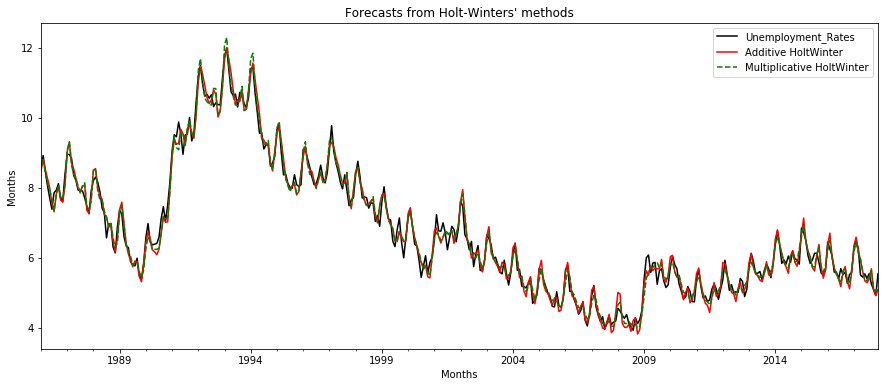

In [47]:
#plot the smoothing results
plt.figure()
ax = train.plot(figsize=(15,6), color='black', title="Forecasts from Holt-Winters' methods" )
ax.set_ylabel("Months")
ax.set_xlabel("rates")
# transfer the datatype to values
smooth_add = fit_add.fittedvalues
smooth_mul = fit_mul.fittedvalues
smooth_add.plot(ax=ax, style='-', color='red', label = "Additive HoltWinter", legend = True)
smooth_mul.plot(ax=ax, style='--', color='green', label = "Multiplicative HoltWinter", legend = True)
plt.show()

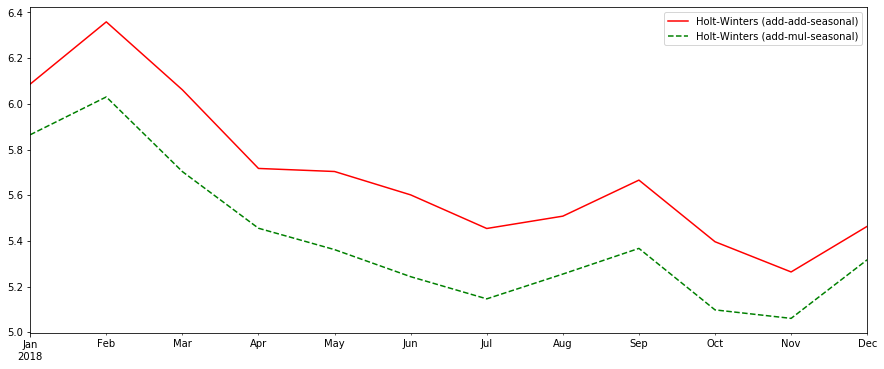

In [48]:
# forecast 12 more data and plot
plt.figure()
forecast_add = fit_add.forecast(12).rename('Holt-Winters (add-add-seasonal)')
ax=forecast_add.plot( style='-', color='red',legend='True')
forecast_mul=fit_mul.forecast(12).rename('Holt-Winters (add-mul-seasonal)')
forecast_mul.plot(ax=ax, style='--', color='green',legend=True)
plt.show()

In [49]:
# Additive Holt-Winters Prediction 
forecast_add

2018-01-01    6.086462
2018-02-01    6.358970
2018-03-01    6.061360
2018-04-01    5.717064
2018-05-01    5.703672
2018-06-01    5.601309
2018-07-01    5.454143
2018-08-01    5.508179
2018-09-01    5.665962
2018-10-01    5.396103
2018-11-01    5.263800
2018-12-01    5.463623
Freq: MS, Name: Holt-Winters (add-add-seasonal), dtype: float64

In [50]:
# Multiplicative  Holt-Winter Prediction 
forecast_mul

2018-01-01    5.864595
2018-02-01    6.030259
2018-03-01    5.703271
2018-04-01    5.455196
2018-05-01    5.361577
2018-06-01    5.243084
2018-07-01    5.145989
2018-08-01    5.254516
2018-09-01    5.366967
2018-10-01    5.097689
2018-11-01    5.060502
2018-12-01    5.317095
Freq: MS, Name: Holt-Winters (add-mul-seasonal), dtype: float64

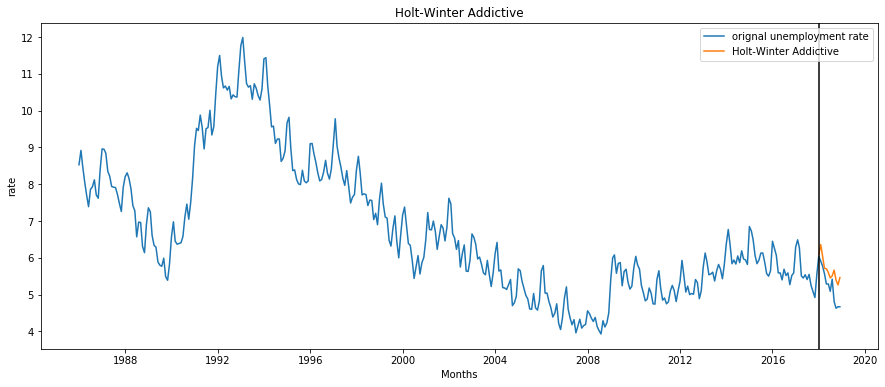

In [51]:
#plot the forecasting results vs orginal data
plt.figure()
plt.plot(data,label='orignal unemployment rate')
plt.plot(forecast_add, label='Holt-Winter Addictive')
plt.legend(loc=1)
plt.title('Holt-Winter Addictive')
plt.xlabel("Months")
plt.ylabel("rate")
plt.axvline(data.index[len(data[:384])],color='black')
plt.show()

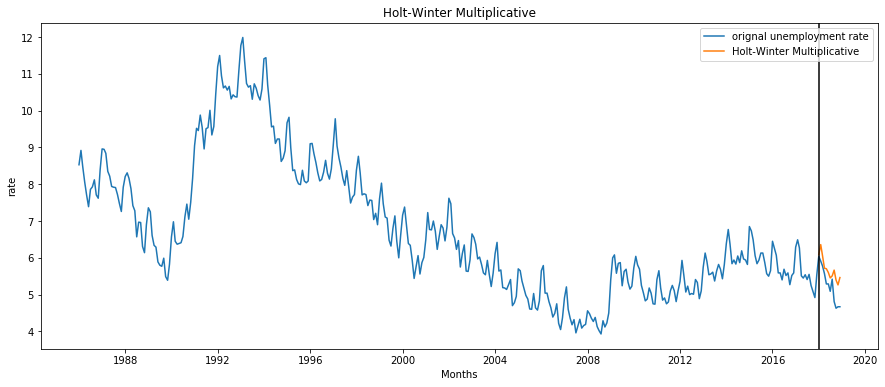

In [52]:
#plot the forecasting results vs orginal data
plt.figure()
plt.plot(data,label='orignal unemployment rate')
plt.plot(forecast_add, label='Holt-Winter Multiplicative')
plt.legend(loc=1)
plt.title('Holt-Winter Multiplicative')
plt.xlabel("Months")
plt.ylabel("rate")
plt.axvline(data.index[len(data[:384])],color='black')
plt.show()

In [53]:
#additive mse
def MSE(a,b):
    return np.mean(np.power(a-b,2)) 
true=np.asarray(validation)
forecast_add=np.asarray(forecast_add).reshape(-1,1) 
MSE_add = MSE(true, forecast_add)
MSE_add

0.2512465166676617

In [54]:
#multi mse
forecast_mul_1=np.asarray(forecast_mul).reshape(-1,1) 
MSE_mul = MSE(true, forecast_mul_1)
MSE_mul

0.10019235853171532

### Model 3 SARIMA Model

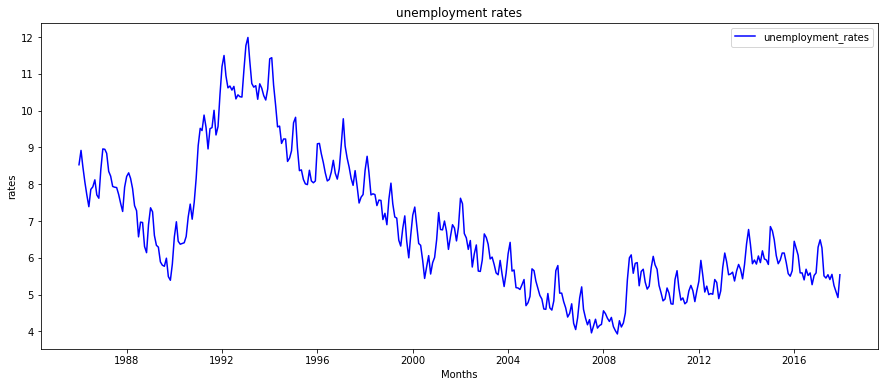

In [55]:
#Pre-processing ：plot the orignial data to check the stationarity
# from the plot, mean-stationarity is not satisfied
# variance-stationary is not able to identify
plt.figure()
plt.plot(train, color='blue', label='unemployment_rates')
plt.title('unemployment rates')
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()

<Figure size 1080x432 with 0 Axes>

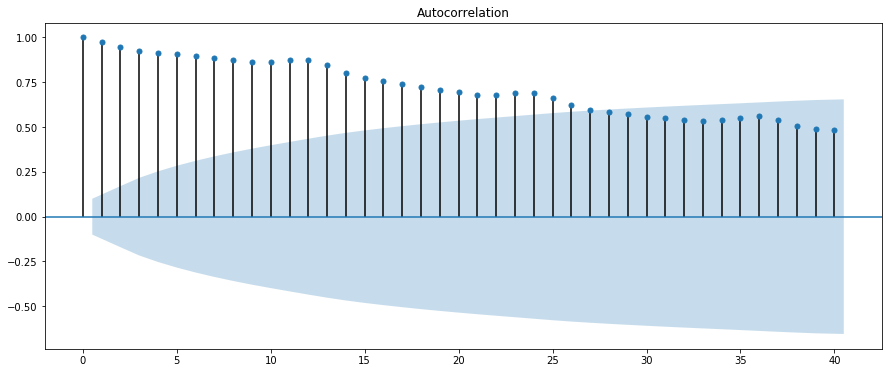

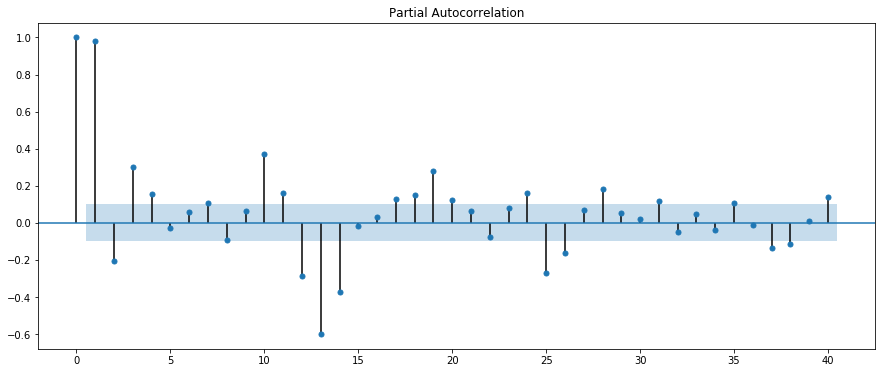

In [56]:
#Pre-processing：acf check  the stationarity
plt.figure()
smt.graphics.tsa.plot_acf(train,lags=40,alpha=0.05)
smt.graphics.tsa.plot_pacf(train,lags=40,alpha=0.05)
plt.show()

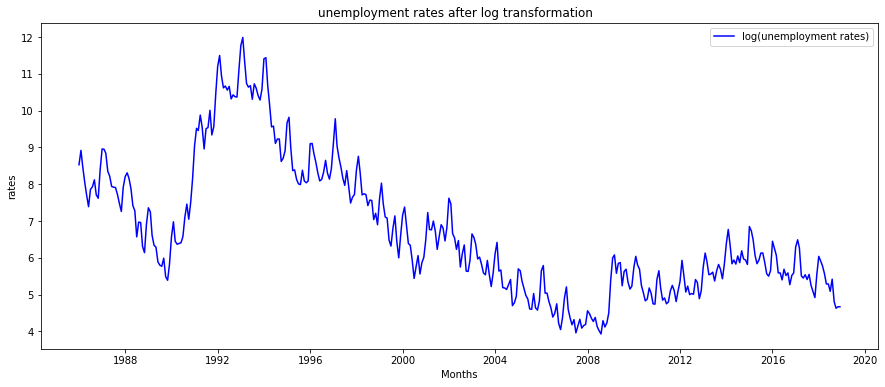

In [57]:
#Pre-processing：plot the log transformation data to check if can reduce fluctuation
train_log=np.log(train)
plt.plot(data, color='blue', label='log(unemployment rates)')
plt.title('unemployment rates after log transformation  ')
plt.xlabel('Months')
plt.ylabel('rates')
plt.legend()
plt.show()

In [58]:
##Pre-processing：differencing to reduce fluctuation

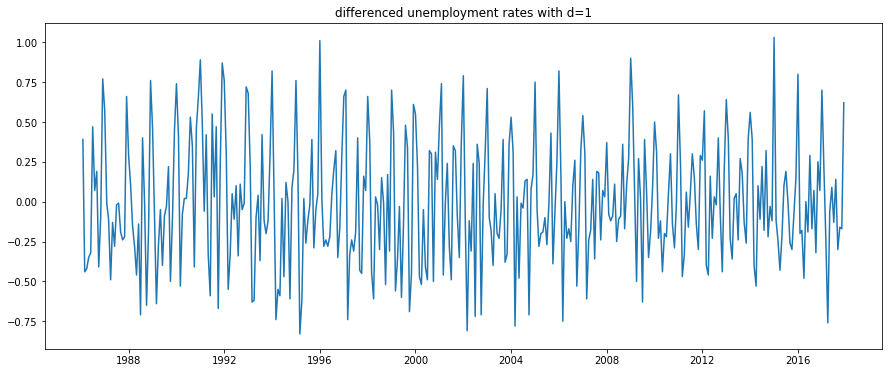

In [59]:
#take the 1st order diff
train_diff_1=train.diff()[1:]
plt.figure()
plt.plot(train_diff_1)
plt.title('differenced unemployment rates with d=1')
plt.show()

<Figure size 1080x432 with 0 Axes>

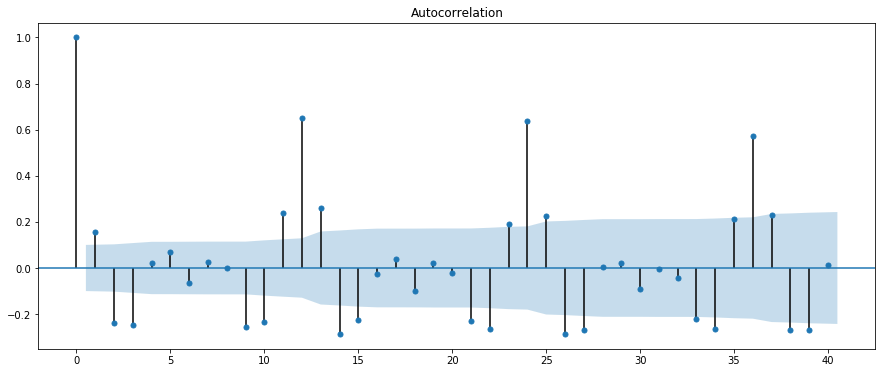

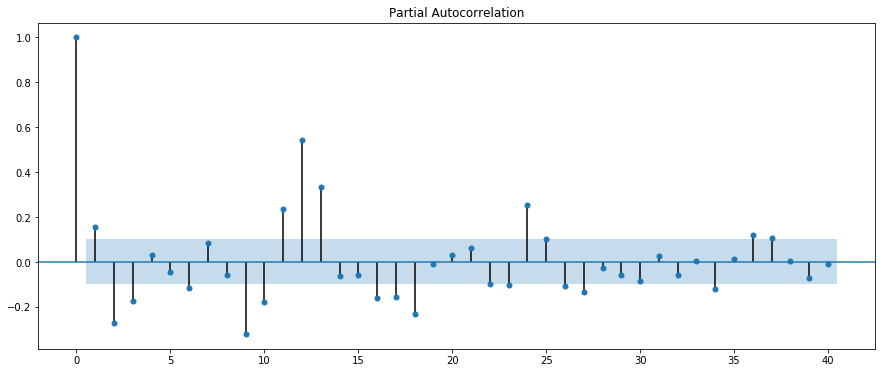

In [60]:
# ACF and PACF for the first differenced series (Plot shows still not satisfy stationary requirement)
plt.figure()
smt.graphics.tsa.plot_acf(train_diff_1,lags=40,alpha=0.05)
smt.graphics.tsa.plot_pacf(train_diff_1,lags=40,alpha=0.05)
plt.show()


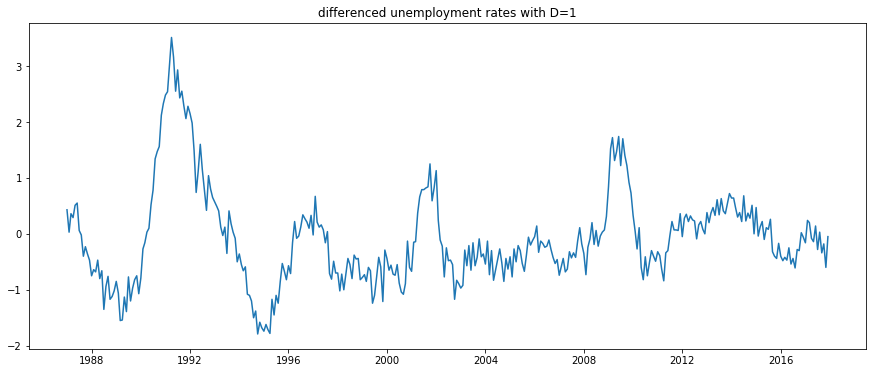

In [61]:
# Try first seasonal difference (Plot shows still not satisfy stationary requirement)
train_diff_2=train.diff(12)[12:]
plt.figure()
plt.plot(train_diff_2)
plt.title('differenced unemployment rates with D=1')
plt.show()

<Figure size 1080x432 with 0 Axes>

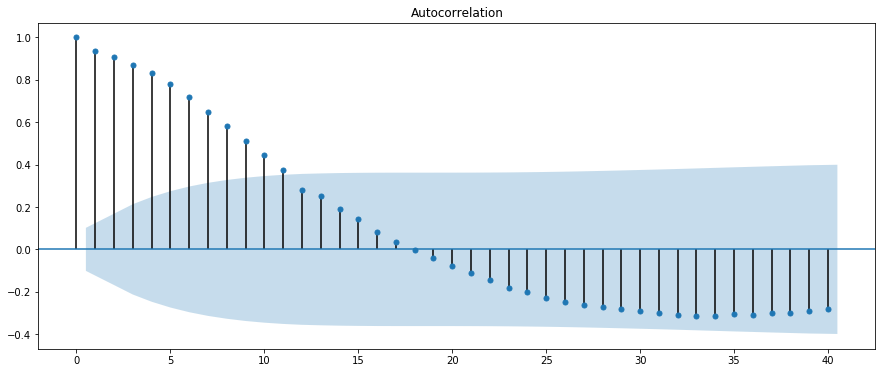

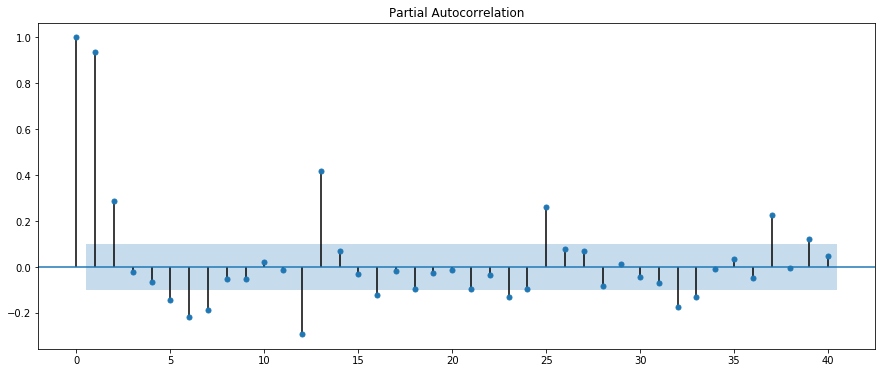

In [62]:
plt.figure()
smt.graphics.tsa.plot_acf(train_diff_2,lags=40,alpha=0.05)
smt.graphics.tsa.plot_pacf(train_diff_2,lags=40,alpha=0.05)
plt.show()

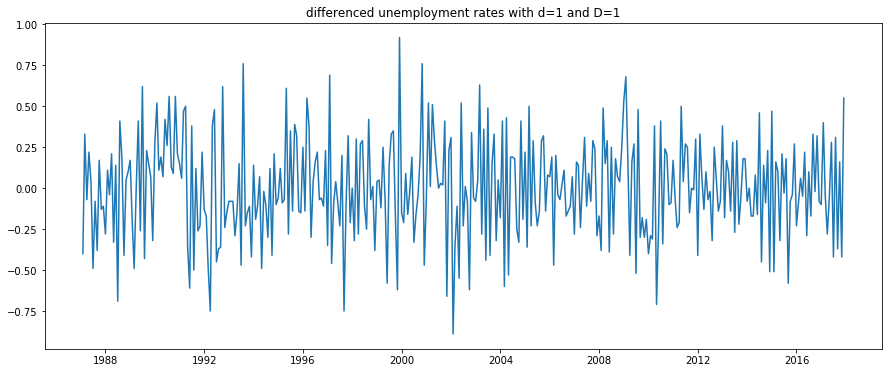

In [63]:
# d=1 andD=1 
train_diff=train_diff_2.diff()[1:]
plt.figure()
plt.plot(train_diff)
plt.title('differenced unemployment rates with d=1 and D=1')
plt.show()

<Figure size 1080x432 with 0 Axes>

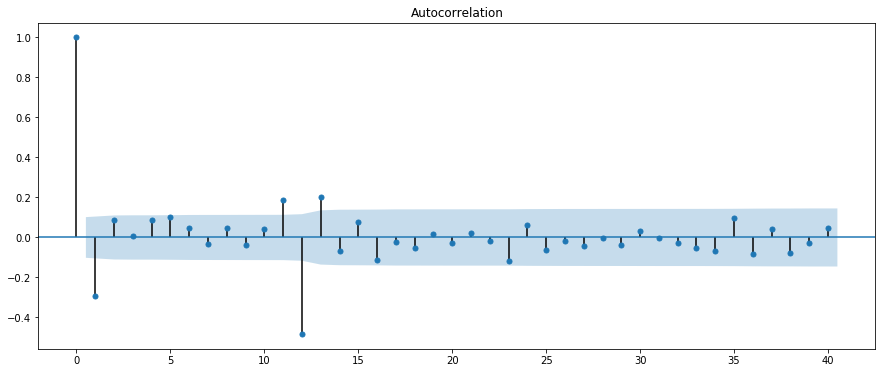

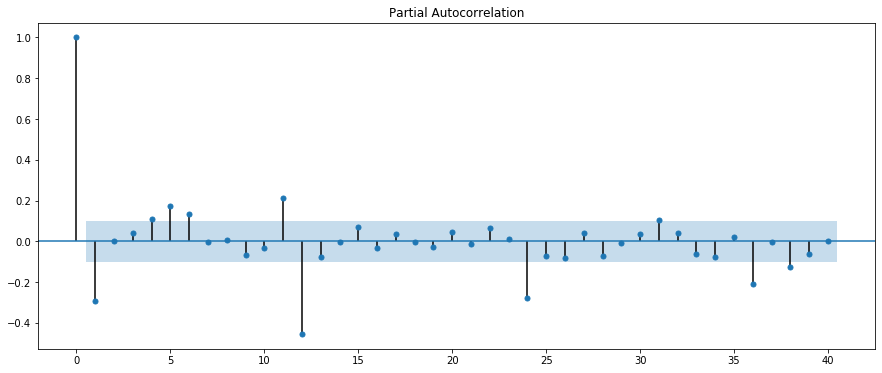

In [64]:
plt.figure()
smt.graphics.tsa.plot_acf(train_diff,lags=40,alpha=0.05)
smt.graphics.tsa.plot_pacf(train_diff,lags=40,alpha=0.05)
plt.show()

In [65]:
#build and fit SARIMA model with optimal order 
# from acf p=1,4,5,6 q=1，2 m=12 P=1 Q=1 d=D=1  

In [66]:
#(5，1，2) (0，1，1)12
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train,order=(5,1,2),seasonal_order=(0,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
SARIMA=model.fit(disp=-1)


In [67]:
#plot residuals 
residuals_SARIMA= pd.DataFrame(SARIMA.resid)[13:]
residuals_SARIMA

,0
Months,
1987-02-01,-2.641071
1987-03-01,1.835879
1987-04-01,0.920860
1987-05-01,-0.037199
1987-06-01,0.360284
...,...
2017-08-01,0.061482
2017-09-01,-0.302722
2017-10-01,-0.080088


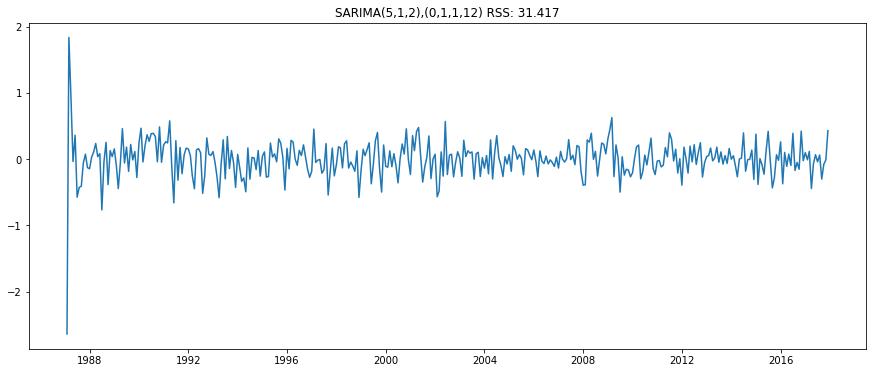

In [68]:
plt.figure()
plt.plot(pd.DataFrame(residuals_SARIMA))
plt.title('SARIMA(5,1,2),(0,1,1,12) RSS: %.3f'% sum((residuals_SARIMA.values)**2))
plt.show()

<Figure size 1080x432 with 0 Axes>

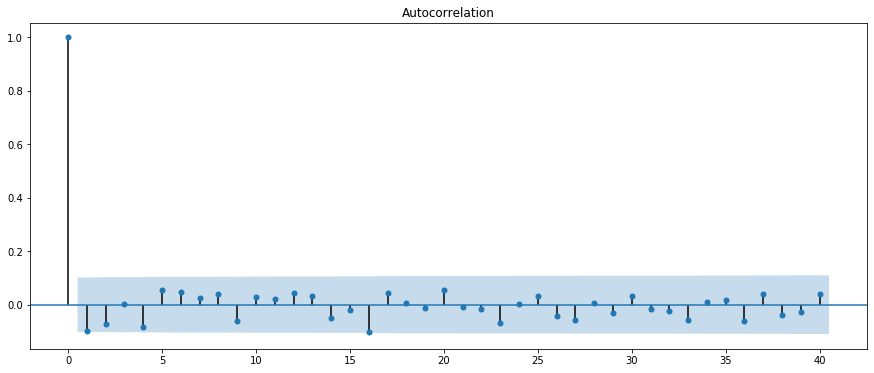

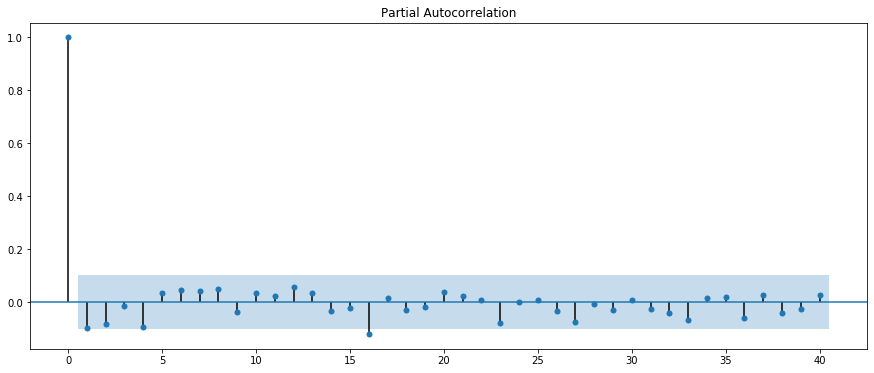

In [69]:
plt.figure()
smt.graphics.tsa.plot_acf(residuals_SARIMA,lags=40,alpha=0.05)
smt.graphics.tsa.plot_pacf(residuals_SARIMA,lags=40,alpha=0.05)
plt.show()

In [70]:
# doing forecast with the fitted 512 model 
forecast_SARIMA= SARIMA.forecast(12)
forecast_SARIMA

2018-01-01    5.996631
2018-02-01    6.194891
2018-03-01    5.870885
2018-04-01    5.475800
2018-05-01    5.413014
2018-06-01    5.369793
2018-07-01    5.358808
2018-08-01    5.414307
2018-09-01    5.460018
2018-10-01    5.226422
2018-11-01    5.137737
2018-12-01    5.377377
Freq: MS, dtype: float64

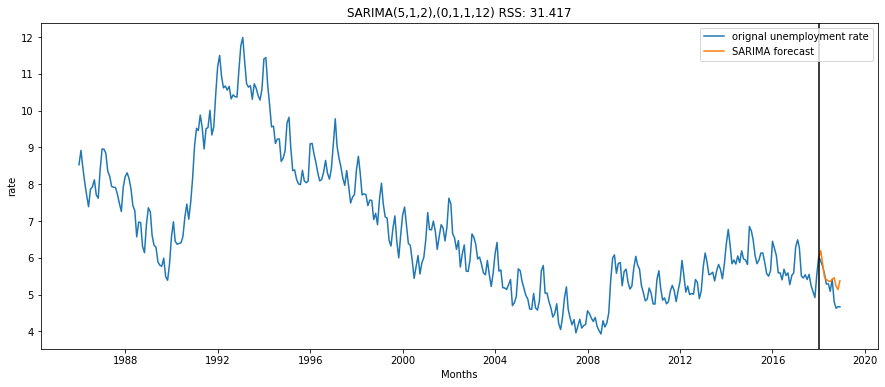

In [71]:
#plot the forecasting results vs orginal data
plt.figure()
plt.plot(data,label='orignal unemployment rate')
plt.plot(validation.index, forecast_SARIMA, label='SARIMA forecast')
plt.legend(loc=1)
plt.title('SARIMA(5,1,2),(0,1,1,12) RSS: %.3f'% sum((residuals_SARIMA.values)**2))
plt.xlabel("Months")
plt.ylabel("rate")
plt.axvline(data.index[len(data[:384])],color='black')
plt.show()

In [72]:
#check the accuracy of the forecast by MSE 
def MSE(a,b):
    return np.mean(np.power(a-b,2)) 
true=np.asarray(validation)
forecast_SARIMA=np.asarray(forecast_SARIMA).reshape(-1,1) 
MSE_SARIMA=MSE(true,forecast_SARIMA)
MSE_SARIMA

0.14094747351445858

### Model 4 Deep Neural Network 

In [ ]:
conda install -c conda-forge keras

In [73]:
#pre-processing： Set  the Radom  Number  Generator  (RNG)seed  so  we  get  the  same  results every time
np.random.seed(1)

In [74]:
##pre-processing：Keras expects arraydata type
train_n=train.values
validation_n=validation.values

In [75]:
##pre-processing：Scaling/normazlization
scaler = MinMaxScaler(feature_range=(0, 1))
train_n=scaler.fit_transform(train_n.reshape(-1,1))

In [76]:
##pre-processing：
#window length---12
time_window = 12
#Createtraining and testing features
Xtrain, Ytrain = [], []
for i in range(time_window, len(train_n)):
    Xtrain.append(train_n[i-time_window:i, 0])
    Ytrain.append(train_n[i, 0])   

In [77]:
 ##pre-processing：
# Convert them from list to array
Xtrain = np.array(Xtrain)  
Ytrain = np.array(Ytrain)  

In [78]:
Ytrain.shape

(372,)

In [79]:
Xtrain.shape

(372, 12)

In [80]:
#Define the Feed Forward NN model

# We only consider one hidden layer which contains 26 neurons
# our time _window is p=12
#width k=26 depth one hidden layer
model = Sequential()
model.add(Dense(26, input_dim=time_window, activation='relu'))
model.add(Dense(1))


Instructions for updating:
Colocations handled automatically by placer.


In [81]:
# complie
model.compile(loss='mean_squared_error', optimizer='adam')

In [82]:
#Visualize the Network
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 26)                338       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 27        
Total params: 365
Trainable params: 365
Non-trainable params: 0
_________________________________________________________________


In [83]:
#train the model
model.fit(Xtrain, Ytrain,  epochs=100, batch_size=37, verbose=0,validation_split=0.05)

Instructions for updating:
Use tf.cast instead.


In [84]:
#Dynamic Forecast
dynamic_prediction = np.copy(train_n)
for i in range(len(train_n), len(train_n)+len(validation_n)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction,next_pred)
    
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

In [85]:
dynamic_prediction.shape

(396, 1)

In [86]:
forecast_nn=dynamic_prediction[-12:]
forecast_nn

array([[5.74829748],
       [5.89332733],
       [5.60333633],
       [5.43497316],
       [5.32540755],
       [5.24426788],
       [5.16702244],
       [5.12417233],
       [4.98993773],
       [4.73731232],
       [4.68301497],
       [4.8461438 ]])

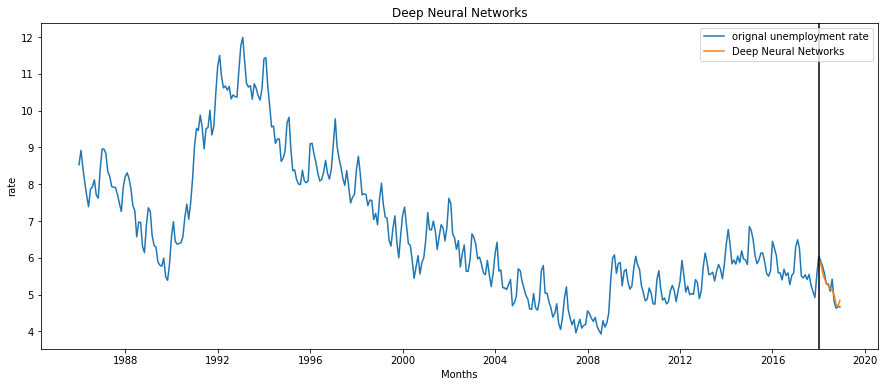

In [87]:
#plot the forecasting results vs orginal data
plt.figure()
plt.plot(data,label='orignal unemployment rate')
plt.plot(validation.index,forecast_nn, label='Deep Neural Networks')
plt.legend(loc=1)
plt.title('Deep Neural Networks')
plt.xlabel("Months")
plt.ylabel("rate")
plt.axvline(data.index[len(data[:384])],color='black')
plt.show()

In [88]:
# accucary
def MSE(a,b):
    return np.mean(np.power(a-b,2)) 
true=np.asarray(validation)
forecast_nn=np.asarray(forecast_nn).reshape(-1,1) 
MSE_nn=MSE(true,forecast_nn)
MSE_nn

0.025557647999501425

## Model Selection  

In [89]:
columns = ["Decompostion_Additive","Decomposition_Multi" ,"Holt-Winter_Additive","Holt-Winter_Multi","SARIMA","DNN"]
models = [final_forecast, final_forecast_m, forecast_add,forecast_mul_1, forecast_SARIMA,forecast_nn]
prediction = pd.DataFrame(np.concatenate(models, axis= 1), columns = columns, index = validation.index)
prediction


,Decompostion_Additive,Decomposition_Multi,Holt-Winter_Additive,Holt-Winter_Multi,SARIMA,DNN
Months,,,,,,
2018-01-01,5.975037,5.963928,6.086462,5.864595,5.996631,5.748297
2018-02-01,6.191527,6.158161,6.358970,6.030259,6.194891,5.893327
2018-03-01,5.783423,5.812372,6.061360,5.703271,5.870885,5.603336
2018-04-01,5.469834,5.551203,5.717064,5.455196,5.475800,5.434973
2018-05-01,5.373598,5.475560,5.703672,5.361577,5.413014,5.325408
2018-06-01,5.234686,5.362008,5.601309,5.243084,5.369793,5.244268
2018-07-01,5.088490,5.051745,5.454143,5.145989,5.358808,5.167022
2018-08-01,5.232986,5.172108,5.508179,5.254516,5.414307,5.124172
2018-09-01,5.410140,5.338022,5.665962,5.366967,5.460018,4.989938


In [90]:
# DNN has smallest MSE
columns = ["Decompostion_Additive","Decomposition_Multi" ,"Holt-Winter_Additive","Holt-Winter_Multi","SARIMA","DNN"]
errors = [MSE_Decomposition_addi, MSE_Decomposition_multi,MSE_add,MSE_mul,MSE_SARIMA,MSE_nn]
prediction = pd.DataFrame(errors, index = columns, columns = ["MSE"])
prediction


,MSE
Decompostion_Additive,0.099044
Decomposition_Multi,0.084120
Holt-Winter_Additive,0.251247
Holt-Winter_Multi,0.100192
SARIMA,0.140947
DNN,0.025558


## Forecast

In [91]:
np.random.seed(1)

In [92]:
## In our forecast, we used all data as the training data for DNN models

#pre-processing：Keras expects arraydata type
data=data.values


In [93]:
##pre-processing：Scaling/normazlization
scaler = MinMaxScaler(feature_range=(0, 1))
data=scaler.fit_transform(data.reshape(-1,1))

In [94]:
##pre-processing：
#window length---12
time_window = 12
#Createtraining and testing features
Xtrain, Ytrain = [], []
for i in range(time_window, len(data)):
    Xtrain.append(data[i-time_window:i, 0])
    Ytrain.append(data[i, 0])   

In [95]:
 ##pre-processing：
# Convert them from list to array
Xtrain = np.array(Xtrain)  
Ytrain = np.array(Ytrain)

In [96]:
#Define the Feed Forward NN model
model = Sequential()
model.add(Dense(26, input_dim=time_window, activation='relu'))
model.add(Dense(1))

In [97]:
# complie
model.compile(loss='mean_squared_error', optimizer='adam')

In [98]:
#train the model
model.fit(Xtrain, Ytrain,  epochs=100, batch_size=37, verbose=0,validation_split=0.05)

In [99]:
#Dynamic Forecast
prediction = np.copy(data)
for i in range(len(data), len(data)+12):
    last_feature = np.reshape(prediction[i-time_window:i], (1,time_window))
    next_pred = model.predict(last_feature)
    prediction = np.append(prediction,next_pred)
    
prediction = prediction.reshape(-1,1)
prediction = scaler.inverse_transform(prediction)

In [100]:
prediction.shape

(408, 1)

In [101]:
# This is thus our forecast for 2019-01 to 2019-12
forecast_2019=prediction[-12:]
forecast_2019

array([[5.17466582],
       [5.32954295],
       [5.4467571 ],
       [5.36313189],
       [5.32308775],
       [5.27852784],
       [5.33416044],
       [5.3219183 ],
       [5.26429295],
       [5.18820159],
       [5.02786817],
       [4.89415884]])

In [102]:
prediction=pd.DataFrame(prediction[-12:],index = ['Jan-19','Feb-19','Mar-19','Apr-19','May-19','Jun-19','Jul-19','Aug-19','Sep-19','Oct-19','Nov-19','Dec-19'], columns = ['Predicted_Unemployment_Rates'])
print(prediction.index)
prediction.to_csv('Group056_Project_Results.csv')

Index(['Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19',
       'Aug-19', 'Sep-19', 'Oct-19', 'Nov-19', 'Dec-19'],
      dtype='object')
